## Recommendation system

In [67]:
import pandas as pd 
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [68]:
credits = pd.read_csv('credits.csv')
movies = pd.read_csv('movies_metadata.csv')
keywords = pd.read_csv('keywords.csv')
links = pd.read_csv('links.csv')
links_small = pd.read_csv('links_small.csv')
ratings_small = pd.read_csv('ratings_small.csv')
ratings = pd.read_csv('ratings.csv')

### Simple recommendation system

The imple recommendation engine for new user recommends the movies that have the highest average rating scores and regardless of users’ preferences. Actually, some weighted scores are more popular, including IMDb formula, but the main idea and the results are quite similar.

In [69]:
allmov = pd.merge(movies, credits, left_index = True, right_index = True)
allmov = pd.merge(allmov, keywords, left_index = True, right_index = True)
allmov.dropna(subset = ["release_date"], inplace = True)
allmov.replace(0, np.nan, inplace = True)
allmov.replace(0, np.nan, inplace = True)

In [70]:
def best_mov(df, cols = ['vote_average','vote_count'], conds = [8.0, 2000.0], n = 5):
    # cols - a list of columns' name for the selection
    # conds - a list of selection conditions for the corresponding columns
    colunms = ['title'] + cols
    target = df[colunms]
    selected1 = target[np.logical_and(target[cols[0]] > conds[0], target[cols[1]] > conds[1])]
    bestm = selected1.sort_values(ascending = False, by = cols).head(n)
    return bestm

best_mov(allmov) 

,title,vote_average,vote_count
314,The Shawshank Redemption,8.5,8358.0
834,The Godfather,8.5,6024.0
12481,The Dark Knight,8.3,12269.0
2843,Fight Club,8.3,9678.0
292,Pulp Fiction,8.3,8670.0


### Content Based Recommender

Recommend movies based on the movie title, the director, the main actors, the genre and the keywords. For this parts, the main idea is from this notebook https://www.kaggle.com/rounakbanik/movie-recommender-systems. In the notebook, the author applied the methods on the small dataset and get a great results. However, since the whole data set contain much more noise, it is difficult to get the same performance. Increasing or decreasing parameters seem does less with the results.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

In [72]:
allmov['cast'] = allmov['cast'].apply(literal_eval)
allmov['crew'] = allmov['crew'].apply(literal_eval)
allmov['genres'] = allmov['genres'].apply(literal_eval)
allmov['keywords'] = allmov['keywords'].apply(literal_eval)

In [73]:
# return a list
def extract(feature):
    token = []
    for i in feature:
        f = i['name']
        token.append(f.lower())
    return token

# combine the words together
def tostr(l):
    t2 = ''
    if len(l) >= 2:
        t2 = ' ' + (l[0]).replace(' ', '') + ' ' + (l[1]).replace(' ', '')
    else:
        for i in l:
            t2 += ' ' + i.replace(' ', '')
    return t2

# remain the space (do not combine the words)
def tostr2(l):
    t2 = ''
    if len(l) >= 2:
        t2 = l[0] + ' ' + l[1]
    else:
        for i in l:
            t2 += i
    return t2

# director infomation
def director(crew):
    for i in crew:
        if i['job'] == 'Director':
            d = i['name']
            return d.replace(' ','')
        else:
            return ''
        
def clean(data):
    if isinstance(data, list):
        return [str.lower(i) for i in data]
    else:
        if isinstance(data, str):
            return str.lower(data)
        else:
            return ''

In [76]:
# clean the data and extract features
allmov['director'] = (allmov['crew'].apply(director)).apply(clean)
allmov['actors'] = ((allmov['cast'].apply(extract)).apply(tostr)).apply(clean)
allmov['genres2'] = ((allmov['genres'].apply(extract)).apply(tostr2)).apply(clean)
allmov['key'] = ((allmov['keywords'].apply(extract)).apply(tostr2)).apply(clean)
allmov['title2'] = (allmov['title']).apply(clean)

In [77]:
# combine all the interedting features together, this will make it easier to calculate TF-IDF vectors
def feature_join(data):
    return data['director'] + data['actors'] + data['genres2'] + data['key'] + ' ' + data['title2']
allmov['feature'] = allmov.apply(feature_join, axis = 1)

In [78]:
allmov['feature']

0        johnlasseter tomhanks timallenanimation comedy...
1         robinwilliams jonathanhydeadventure fantasybo...
2        howarddeutch waltermatthau jacklemmonromance c...
3        forestwhitaker whitneyhouston angelabassettcom...
4         stevemartin dianekeatoncomedybaby midlife cri...
                               ...                        
45457    georgesméliès georgesmélièsdrama action robin ...
45459    saulblinkoff jimmybennett petercullendrama cen...
45460     georgesméliès georgesmélièsaction drama betrayal
45461    georgesméliès jeanned'alcy georgesméliès satan...
45462                                             queerama
Name: feature, Length: 45376, dtype: object

In [79]:
# calculate TF-IDF vectors
tfidf = TfidfVectorizer(stop_words = 'english')

tfidf_feature = tfidf.fit_transform(allmov['feature'])

In [80]:
# calculate the cosine similarity
cosine = cosine_similarity(tfidf_feature, tfidf_feature)

In [81]:
index = pd.Series(allmov.index, index = allmov['title']).drop_duplicates()

def recommend(title, cosine):
    idx = index[title]
    pair_sim = list(enumerate(cosine[idx]))
    sim = (sorted(pair_sim, key = lambda x: x[1], reverse = True))[1:10]
    movidx = [i[0] for i in sim]
    return allmov['title'].iloc[movidx]

In [82]:
recommend('The Godfather', cosine)

8871            Police Story
1376            First Strike
10354         Police Story 2
5109        The Young Master
10357       New Police Story
110      Rumble in the Bronx
10721              Project A
12912           Babylon A.D.
11179           Executioners
Name: title, dtype: object

In [83]:
recommend('The Shawshank Redemption', cosine)

23516    Blood of Redemption
12254        The Bucket List
33908    Behind Locked Doors
4864            The Majestic
5148             High Crimes
17280          Cinema Verite
3028        Cradle Will Rock
13561         The Lucky Ones
2176              The Player
Name: title, dtype: object

### Collaborative Filtering

Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based Collaborative Filtering, which is based on a similarity matrix calculated by cosine similarity. https://arxiv.org/pdf/1503.07475.pdf

In [86]:
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.metrics import RootMeanSquaredError

In [ ]:
movies.rename(columns = {'id':'movieId'}, inplace = True)
ratings_sub = pd.merge(ratings_small, movies[['movieId', 'title', 'original_language']], on = 'movieId')

We can select certain feature for interesting movies by roughly select the movie features. For example, if one like English movies, the following funcctions can be applied to the dataset.

In [ ]:
def choose_language(language):
    lan_ratings_sub = ratings_sub[ratings_sub['original_language'] == language]
    return lan_ratings_sub

Now, we need first do some preprocessing wordk. Notice that the user IDs are ordered sequentially with no missing numbers, but the movie IDs are not. Hence, we need to change them to a sequential set.

In [ ]:
# create a mapping for movie ids
unique_movie_ids = set(ratings_sub.movieId.values)
movieidx = {}
count = 0
for m_id in unique_movie_ids:
    movieidx[m_id] = count
    count += 1

In [ ]:
# add them to the data frame
ratings_sub['movie_idx'] = ratings_sub.apply(lambda row: movieidx[row.movieId], axis=1)

In [ ]:
ratings_sub.head()

,userId,movieId,rating,timestamp,movie_idx,title,original_language
0,1,1371,2.5,1260759135,914,Rocky III,en
1,4,1371,4.0,949810302,914,Rocky III,en
2,7,1371,3.0,851869160,914,Rocky III,en
3,19,1371,4.0,855193404,914,Rocky III,en
4,21,1371,3.0,853852263,914,Rocky III,en


In [ ]:
df_ratings = ratings_sub.drop(columns=["timestamp", "original_language", "movieId", "title"])

#### SVD

In [ ]:
train_data, test_data = train_test_split(df_ratings, test_size = 0.2)

In [ ]:
n_users = df_ratings.userId.nunique()
n_items = df_ratings.movie_idx.nunique()

print(n_users, n_items)

671 2830


In [ ]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[3]-1] = line[2]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[3]-1] = line[2]

In [ ]:
def rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

Training the SVD model.

In [ ]:
u, s, vt = svds(train_data_matrix, k = 8)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF RMSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF RMSE: 2.9474166124884773


#### Neural Network

MF extracts the features automatically using only ratings and we can feed them into a model like random forest and neural network.

In [ ]:
train_data.head()

,userId,rating,movie_idx
2924,421,5.0,290
10307,363,5.0,737
27427,119,4.0,1086
5395,163,2.5,457
42824,387,4.0,1457


In [ ]:
n_users = df_ratings.userId.max() + 1
n_movies = df_ratings.movie_idx.max() + 1

train_data, test_data = train_test_split(df_ratings, test_size = 0.2)

# initialize variables
k = 8
mu = train_data.rating.mean()

In [ ]:
user_input = Input(shape=(1,)); movie_input = Input(shape=(1,))
u_embed = Flatten()(Embedding(n_users, k)(user_input))
m_embed = Flatten()(Embedding(n_movies, k)(movie_input))
x = Concatenate()([u_embed, m_embed])

In [ ]:
# the neural network
x = Dense(200, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)

model = Model(inputs = [user_input, movie_input], outputs = x)
model.compile(loss = 'mse', optimizer = Adam(lr = 0.001), metrics = [RootMeanSquaredError(name = 'rmse')],)

epochs = 20
result = model.fit(
  x = [train_data.userId.values, train_data.movie_idx.values],
  y = train_data.rating.values - mu,
  epochs = epochs,
  batch_size = 180,
  validation_data = ([test_data.userId.values, test_data.movie_idx.values], test_data.rating.values - mu)
)

Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 1.0154 - rmse: 1.0077 - val_loss: 0.8512 - val_rmse: 0.9226
Epoch 2/20
200/200 [==============================] - 1s 4ms/step - loss: 0.8464 - rmse: 0.9200 - val_loss: 0.8051 - val_rmse: 0.8973
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.8085 - rmse: 0.8992 - val_loss: 0.8017 - val_rmse: 0.8954
Epoch 4/20
200/200 [==============================] - 1s 4ms/step - loss: 0.7866 - rmse: 0.8869 - val_loss: 0.7950 - val_rmse: 0.8916
Epoch 5/20
200/200 [==============================] - 1s 3ms/step - loss: 0.7726 - rmse: 0.8790 - val_loss: 0.7900 - val_rmse: 0.8888
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.7645 - rmse: 0.8744 - val_loss: 0.7870 - val_rmse: 0.8872
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.7536 - rmse: 0.8681 - val_loss: 0.7824 - val_rmse: 0.8845
Epoch 8/20
200/200 [==============================] - 1s 3ms/s

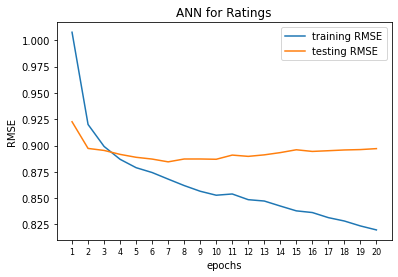

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
# axes[0].plot(result.history['loss'], label = "training loss") 
# axes[0].plot(result.history['val_loss'], label = "testing loss")
# axes[0].set_title('ANN for Ratings')
# axes[0].set_xlabel('epochs')
# axes[0].set_ylabel('RMSE')
# axes[0].legend()

axes.plot(result.history['rmse'], label = "training RMSE") 
axes.plot(result.history['val_rmse'], label = "testing RMSE")
axes.set_title('ANN for Ratings')
axes.set_xlabel('epochs')
axes.set_ylabel('RMSE')
axes.legend()
ticks = [int(i) for i in np.linspace(0, 19, 20)]
labels = [i + 1 for i in ticks]
axes.set_xticks(ticks)
axes.set_xticklabels(labels, fontsize = 8);